# <font color='blue'> Solution Planning </font>

## Business Problem

**What is the business problem?**
1. Select the most valuable customers to join the "Loyals" loyalty program.

2. Answering business questions to the marketing team.

### Output

**What will I deliver? / Where does the business team want to see it?**

* 1) List in xls / send by email. It must contain customers who will join Loyals (loyalty program).
    - Format:
   
| client_id | is_loyal |
|-----------|----------|
|1          |yes       |
|2          |no        |

* 2) PDF report answering business questions / send by email and present to the marketing team:
     - Who are the people eligible to participate in the Loyals program?
     - How many customers will be part of the group?
     - What are the main characteristics of these customers?
     - What is the percentage of revenue contribution from Loyals?
     - What is the expected revenue for this group for the coming months?
     - What are the conditions for a person to be eligible for Loyals?
     - What are the conditions for a person to be removed from Loyals?
     - What is the guarantee that the Loyals program is better than the rest of the base?
     - What actions can the marketing team take to increase revenue?

### Input

**Data sources:**
     Dataset "Ecommerce.csv", containing e-commerce sales for the period of one year.

**Tools:**
     Python 3.8.13, Jupyter Notebook, Git, Github.

### Process

**Type of problem:**
Separation of customers by groups.
    
**Main methods:**
    clustering.

**Business Questions:**
* 1) Who are the people eligible to participate in the Loyals program?
    - What does it mean to be eligible? / What are higher "value" customers? (depending on business area)
        - Invoicing:
             - High average ticket
             - High LTV (sum of customer revenue)
             - Low recency (time since last purchase)
             - High basket size (qty products purchased per purchase)
             - Low churn probability (would use the output of a model)
             - High LTV Prediction (would use output from a model)
             - High propensity to buy (would use the output of a model)
        - Cost:
             - Low return rate
        - Shopping experience:
             - High average of the evaluations

 PS: the features will be created in feature engineering.
 
 
* 2) How many customers will be part of the group?
    - Number of customers
    - % in relation to the total number of clients
    
    
* 3) What are the main characteristics of these customers?
    - Write customer characteristics:
        - Age
        - Country
        - Wage
        - Location
     - Write key customer buying behaviors (business metrics)
        - See clustering features (question 1)
         
 For look alike: prospecting similar customers on the internet


* 4) What percentage of revenue contribution comes from Loyals?
    - Calculate the company's total revenue during the year.
    - Calculate the revenue (%) for the Loyals cluster only.
   
   
* 5) What is the expected revenue for this group for the coming months?
    - Loyals LTV calculation (with moving average, time series, arima..)
    - Time Series (ARMA, ARIMA, HoltWinter, etc.)
    - Cohort analysis (with time, location, product..)

 There must be a billing target, consult business.
    
    
* 6) What are the conditions for a person to be eligible for Loyals?
    - Set the evaluation interval (every 1 month, 3 months..)
    - The client's "performance" should be close to the Loyals cluster average.
    
    
* 7) What are the conditions for a person to be removed from Loyals?
    - Customer "performance" is no longer closer to the Loyals cluster average.
   
   
* 8) What is the guarantee that the Loyals program is better than the rest of the base?
    - A/B test
    - Hypothesis test


* 9) What actions can the marketing team take to increase revenue?
    - Discount
    - Purchase preference
    - Cheaper shipping
    - Visit the company
    - Offer personal stylist
    - Recommend cross selling
    - Offer exclusive content

# <font color='blue'> 0.0 Imports </font>

In [1]:
import pandas   as pd
import numpy    as np
import seaborn  as sns
import inflection

from matplotlib           import pyplot   as plt
from plotly               import express  as px
from IPython.display      import Image
from IPython.core.display import HTML
from tabulate             import tabulate
from yellowbrick.cluster  import KElbowVisualizer, SilhouetteVisualizer
import umap.umap_ as umap

from sklearn              import cluster  as c
from sklearn              import metrics  as m

import warnings

C:\Users\SBG\anaconda3\envs\clustering\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <font color='blue'> 0.1 Helper Functions </font>

In [2]:
def jupyter_settings():
    %matplotlib inline
       
    plt.style.use('bmh')
    plt.rcParams ['figure.figsize'] = [22,12]
    plt.rcParams ['font.size'] = 12
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
       
    warnings.filterwarnings("ignore")
    
jupyter_settings()

# <font color='blue'> 0.2 Load dataset </font>

In [3]:
# read data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

In [4]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [5]:
df_raw = df_raw.drop('Unnamed: 8', axis=1).copy()
df_raw.sample(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
119218,546534,20719,WOODLAND CHARLOTTE BAG,10,12-Mar-17,0.85,16150.0,United Kingdom
410382,572103,22918,HERB MARKER PARSLEY,4,18-Oct-17,0.65,17571.0,United Kingdom


# <font color='blue'> 1.0 Data description </font>

In [6]:
df1 = df_raw.copy()

## <font color='black'> 1.1 Rename columns </font>

In [7]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
# columns names
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerId', 'Country']

# transforming to underscore the names and put into lowcase
snakecase = lambda x: inflection.underscore( x )

# creating a list with a new snakecase columns name and indicating the new one
cols_new = list( map( snakecase, cols_old ) )

# renaming columns name
df1.columns = cols_new

### <font color='black'>  Feature Description </font>

In [9]:
# Feature meanings
tab_meanings = [['Columns', 'Meaning'],
        ['invoice_no', 'unique identifier of each transaction'],
        ['stock_code', 'item code'],
        ['description', 'item name'],
        ['quantity', 'quantity of each item purchased per transaction'],
        ['invoice_date', 'the day the transaction took place'],
        ['unit_price', 'product price per unit'],
        ['customer_id', 'unique customer identifier'],
        ['country', 'customer\'s country of residence']
      ]
print(tabulate(tab_meanings, headers='firstrow', stralign='left', tablefmt='simple'))

Columns       Meaning
------------  -----------------------------------------------
invoice_no    unique identifier of each transaction
stock_code    item code
description   item name
quantity      quantity of each item purchased per transaction
invoice_date  the day the transaction took place
unit_price    product price per unit
customer_id   unique customer identifier
country       customer's country of residence


## <font color='black'> 1.2 Data dimensions </font>

In [10]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 541909
Number of columns 8


## <font color='black'> 1.3 Data types </font>

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## <font color='black'> 1.4 Check NA </font>

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## <font color='black'> 1.5 Replace NA </font>

In [13]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])


In [14]:
print(('Removed data: {:.2f} %').format (100*(1-(df1.shape[0]/df_raw.shape[0]))))

Removed data: 24.93 %


In [15]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## <font color='black'> 1.6 Change types </font>

In [16]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [17]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


In [18]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

In [19]:
# customer id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [20]:
# invoice_no
#df1['invoice_no'] = df1['invoice_no'].astype(int)
#there are letters on invoice, so let it like object(string). Ex: 'C536379', 'C554197'

In [21]:
# stock_code
#df1['stock_code'] = df1['stock_code'].astype(int)
#there are letters on stock_code, so let it like object(string). Ex: '85123A', '84406B'

In [22]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


## <font color='black'> 1.7 Descriptive statistics  </font>

# <font color='blue'> 2.0 Feature Engineering </font>

In [23]:
df2 = df1.copy()

## <font color='black'> 2.1 Feature creation  </font>

In [24]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


**Let's start adjusting the dataset to build an RFM Segmentation Model (Recency, Frequency, Monetary Value)**

In [25]:
# data reference
df_ref = df2.drop(['invoice_no','stock_code','description','quantity','invoice_date','unit_price','country'],axis=1).drop_duplicates(ignore_index=True)


In [26]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [27]:
# Gross Revenue = quantity*price
df2['gross_revenue'] = df2['quantity']*df2['unit_price']

# Monetary
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

# Total invoices
df_freq=df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref,df_freq, on='customer_id',how='left')



In [28]:
# creating another feature
# Avg Ticket
df_avg_ticket = df2[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')

In [29]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# <font color='blue'> 3.0 Variable Filtering </font>

In [30]:
df3 = df_ref.copy()

# <font color='blue'> 4.0 Exploratory Data Analysis </font>

In [31]:
df4 = df3.copy()

# <font color='blue'> 5.0 Data Preparation </font>

In [32]:
df5 = df4.copy()

# <font color='blue'> 6.0 Feature Selection </font>

In [33]:
df6 = df5.copy()

# <font color='blue'> 7.0 Hyperparameter Fine-Tunning </font>

In [34]:
# drop customer id
X = df6.drop(columns=['customer_id'])

In [35]:
clusters = [2,3,4,5,6,7] # add k = 7

We need two properties for a good clustering:

- Compactness: smallest possible distance between the points of the same cluster.
- Separation: greatest possible distance between the points of different clusters.

Let's use k-means with 2 metrics: 

1 - Within-Cluster Sum of Square (WSS) - calculates Compactness 

2 - Silhouette Score (SS) - calculates Compactness and Separation

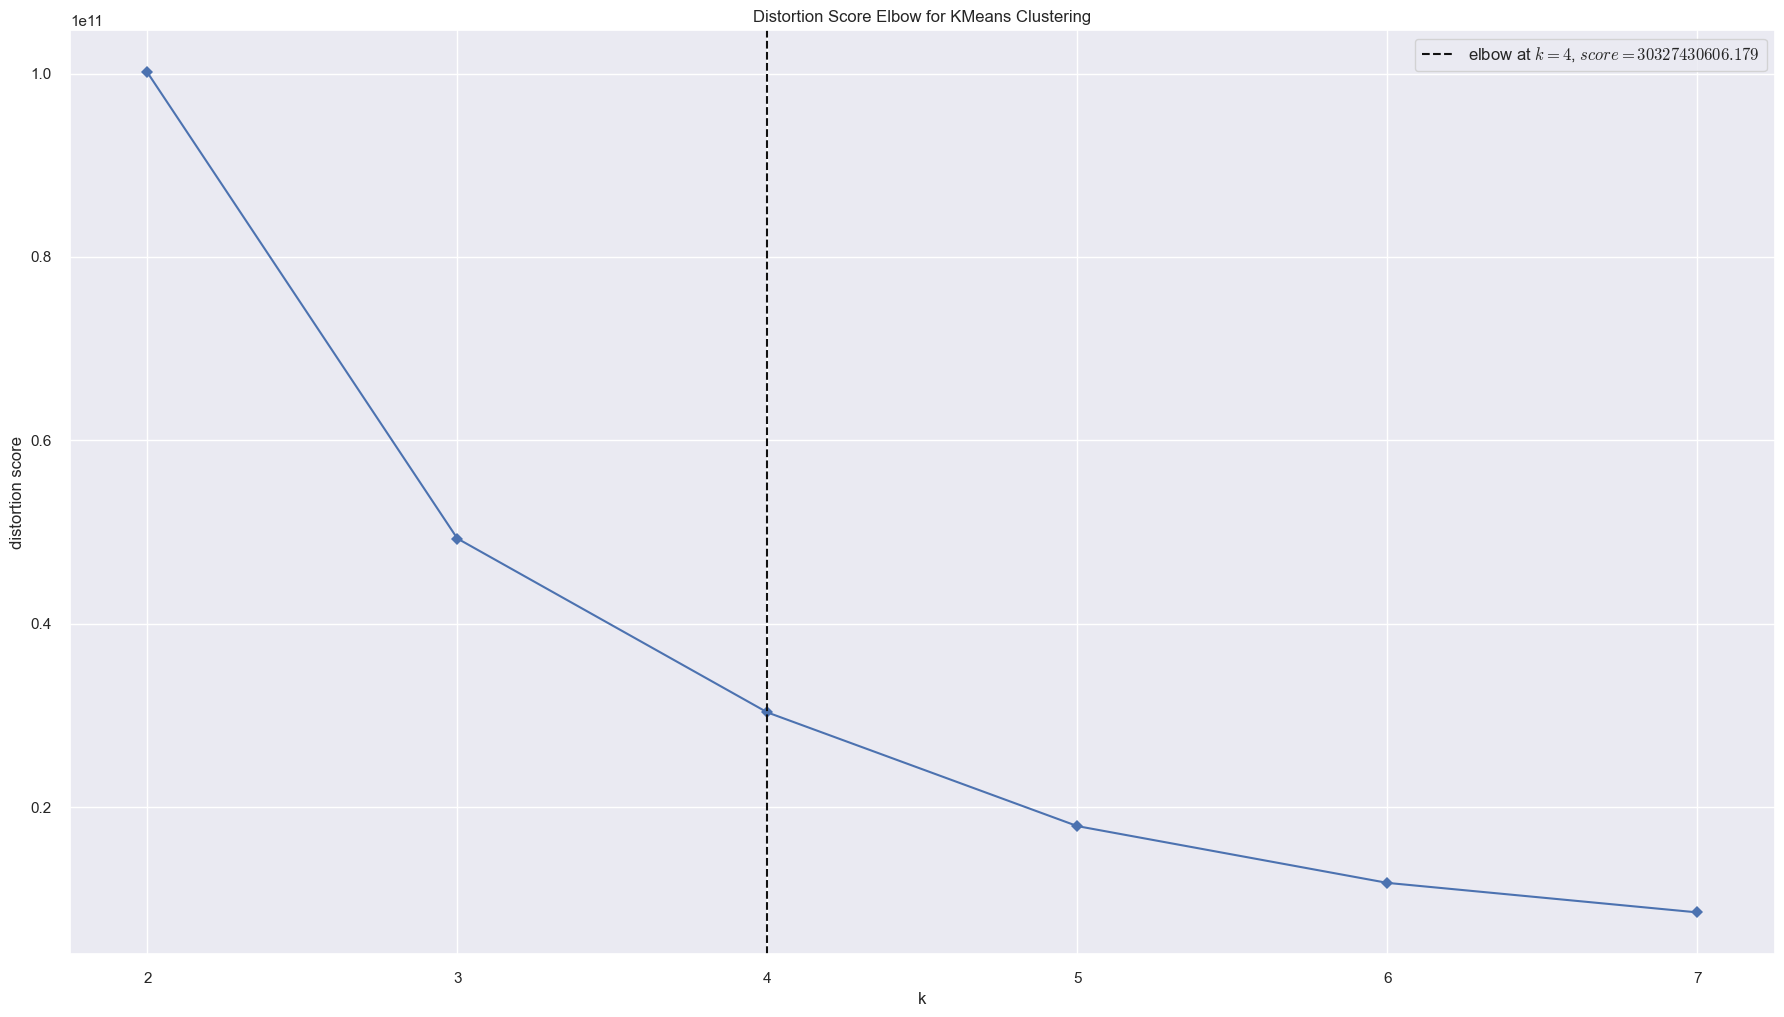

In [36]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

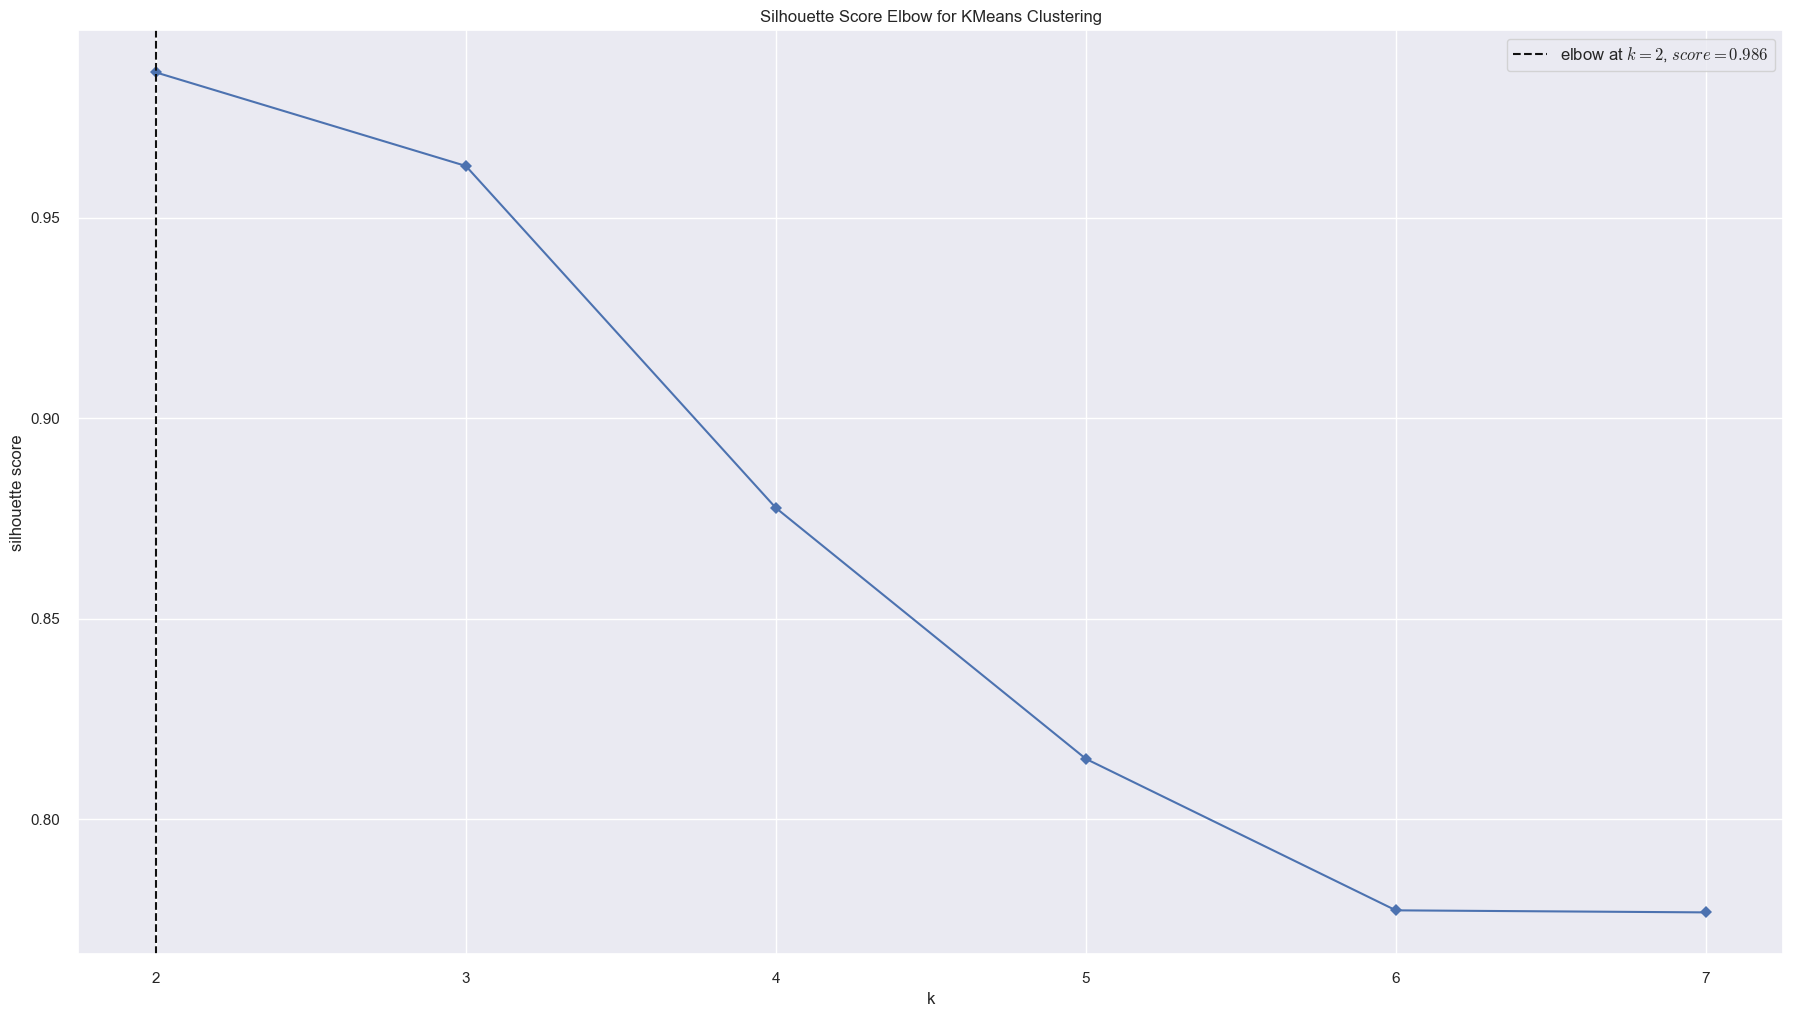

In [37]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## <font color='black'> 7.1 Silhouette Analysis (WSS)  </font>

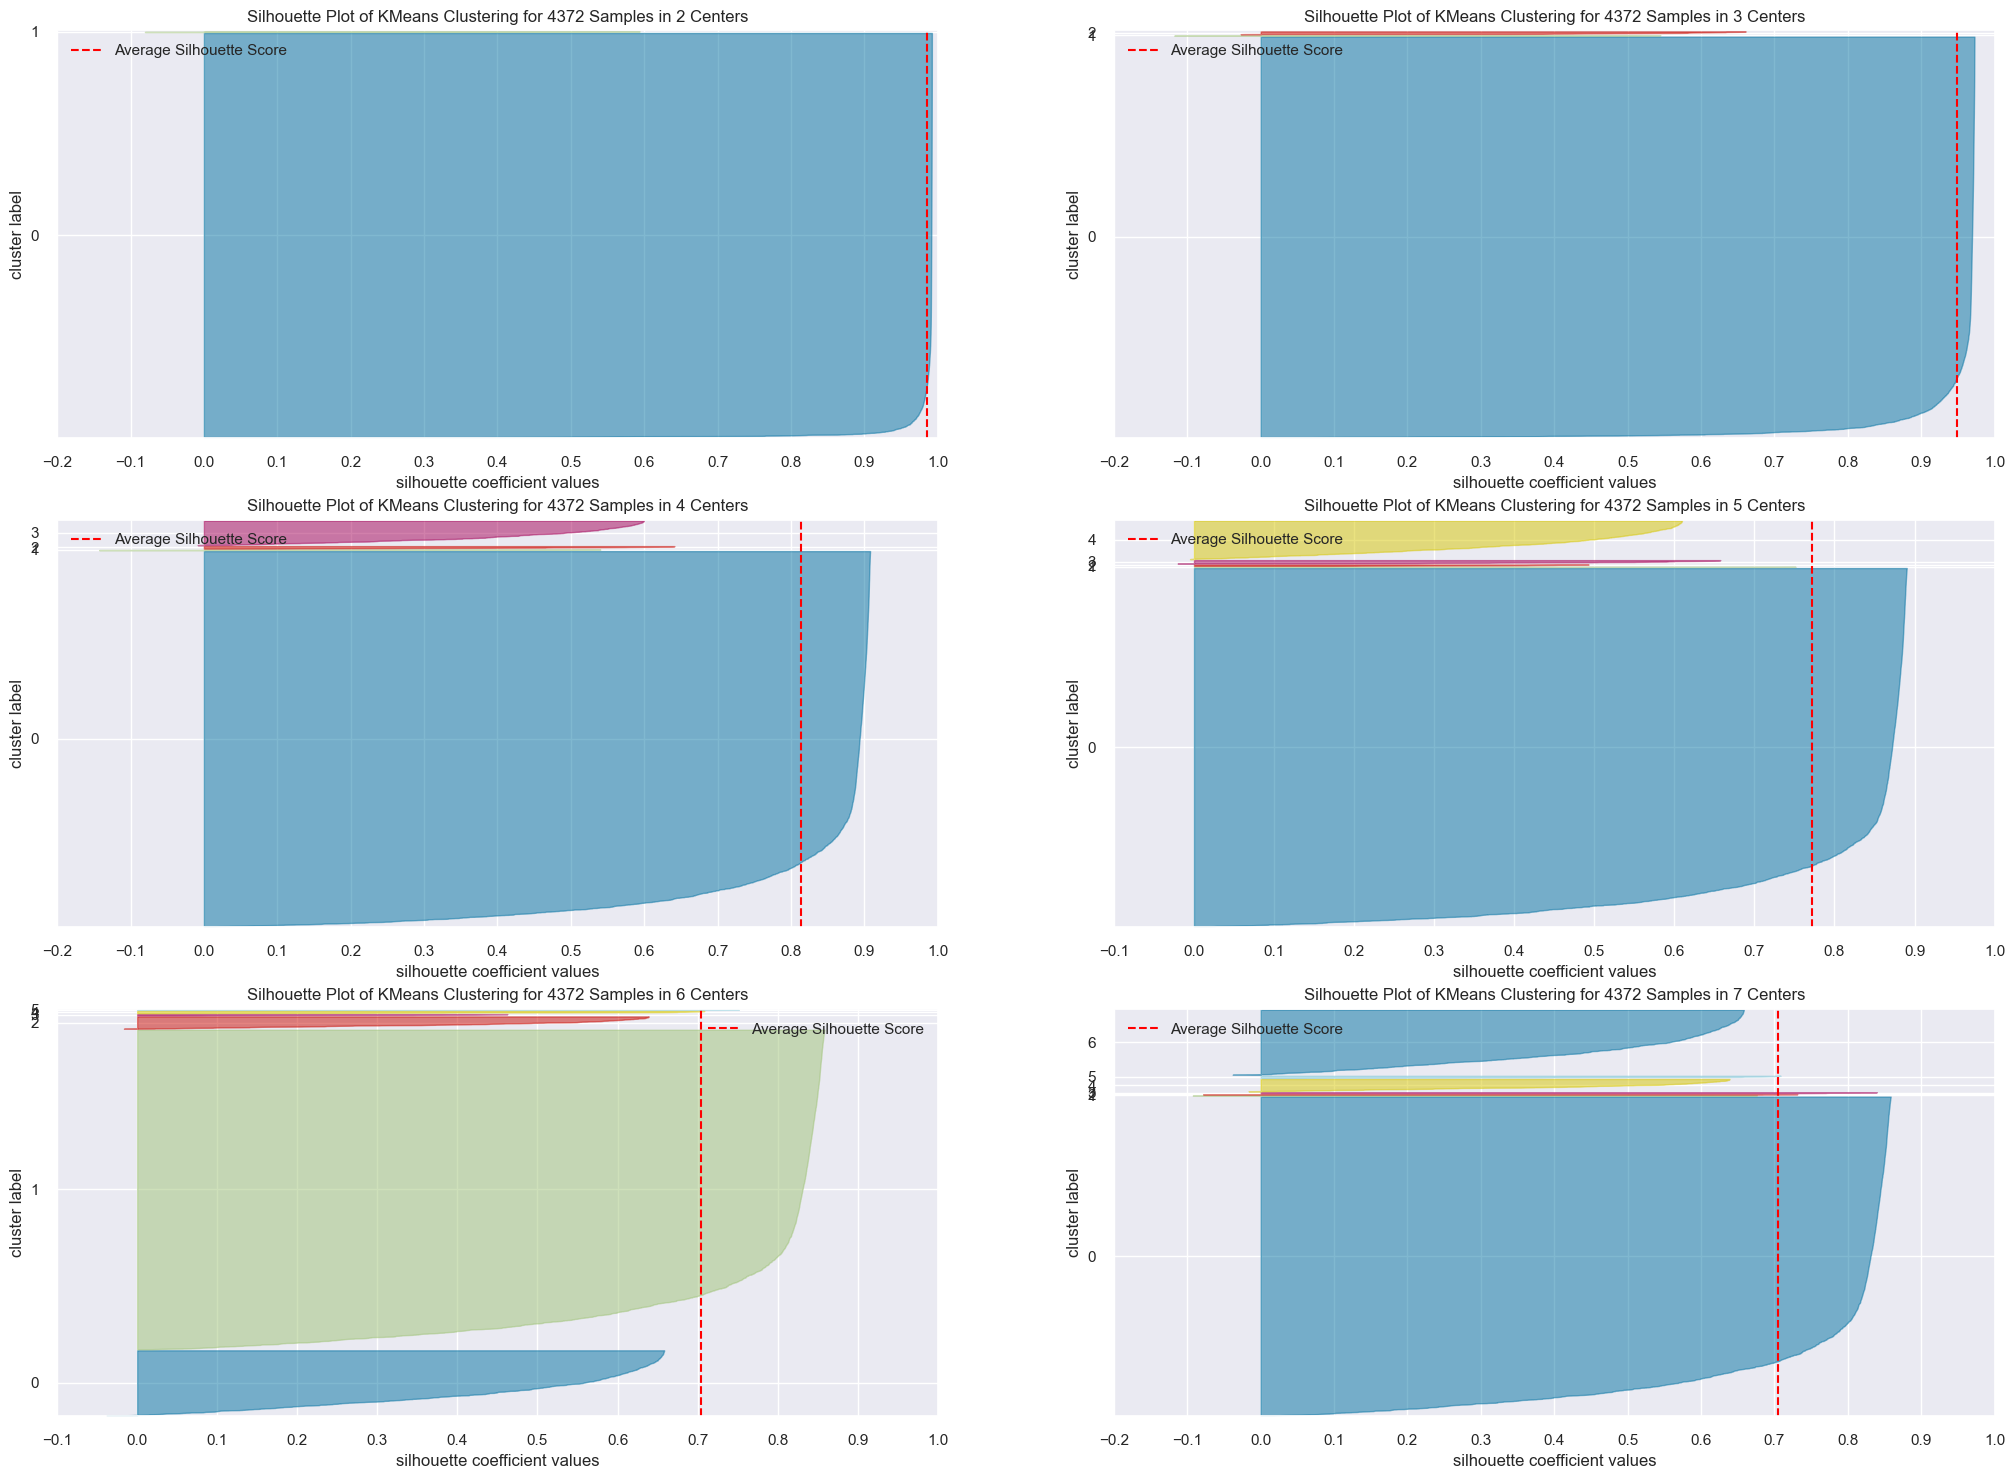

In [38]:
fig, ax = plt.subplots(3,2, figsize=(25,18))
for k in clusters:
    km=c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

In [39]:
#  There is a big cluster in all 'k's and the others are smaller.From k=3 we can see that some points of the big cluster are approaching the others clusters

# <font color='blue'> 8.0 Model Training </font>

## <font color='black'> 8.1 K-Means  </font>

In [41]:
# model definition
k=4
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels= kmeans.labels_
labels

array([3, 0, 3, ..., 0, 0, 0])

## <font color='black'> 8.2 Cluster Validation  </font>

In [42]:
# WSS (Within-cluster Sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))


WSS value: 40056506734.60243
SS value: 0.8139972028952444


# <font color='blue'> 9.0 Cluster Analysis </font>

In [43]:
df9=df6.copy()
df9['cluster'] = labels

In [44]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,5288.63,302,35,16.950737,3
1,13047,3079.10,31,18,15.709694,0
2,12583,7187.34,2,18,28.634821,3
3,13748,948.25,95,5,33.866071,0
4,15100,635.10,330,6,105.850000,0


## <font color='black'> 9.1 Visualization Inspection  </font>

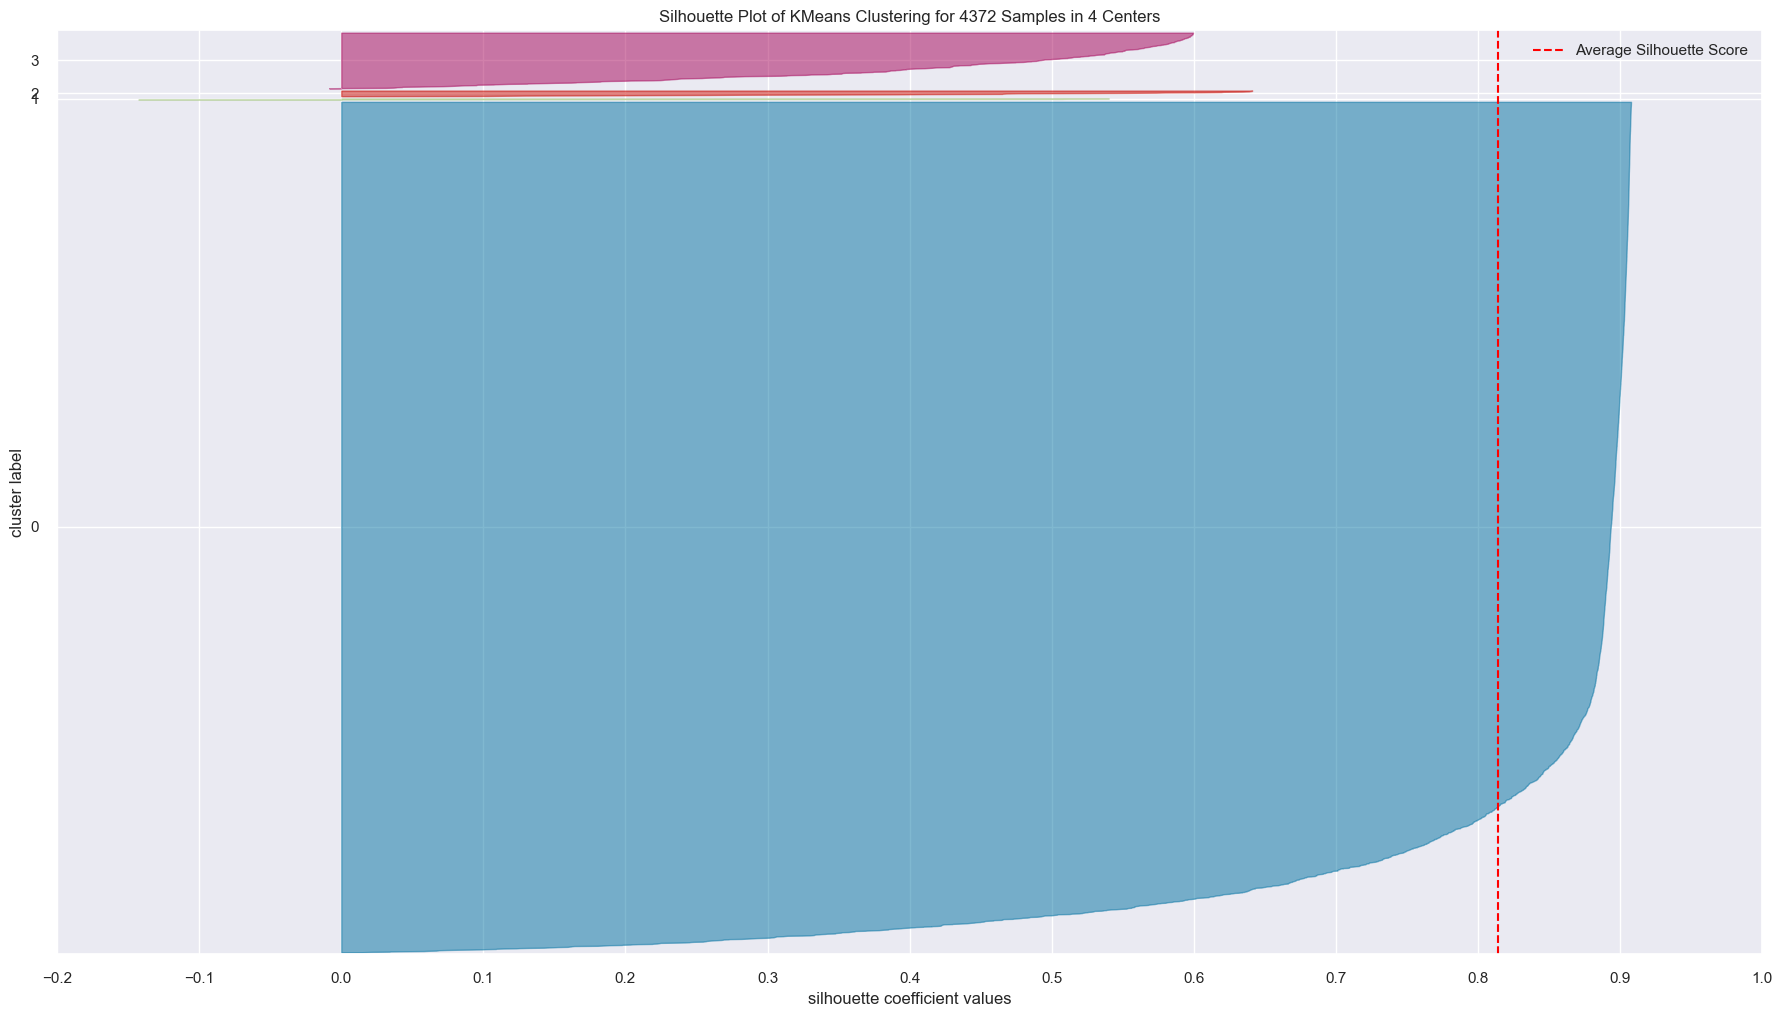

In [45]:
visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## <font color='black'> 9.2 2d Plot  </font>

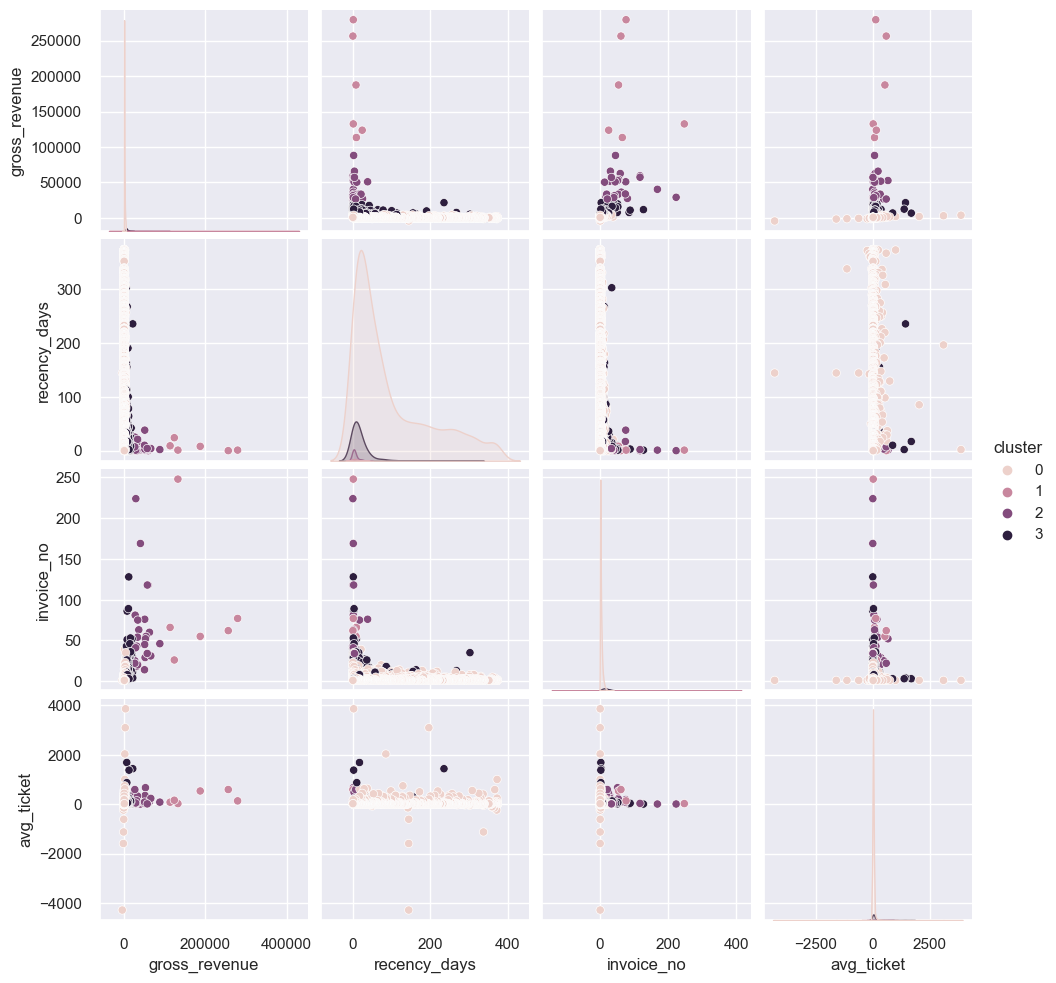

In [46]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot (df_viz,hue='cluster');

## <font color='black'> 9.3 UMAP  </font>


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

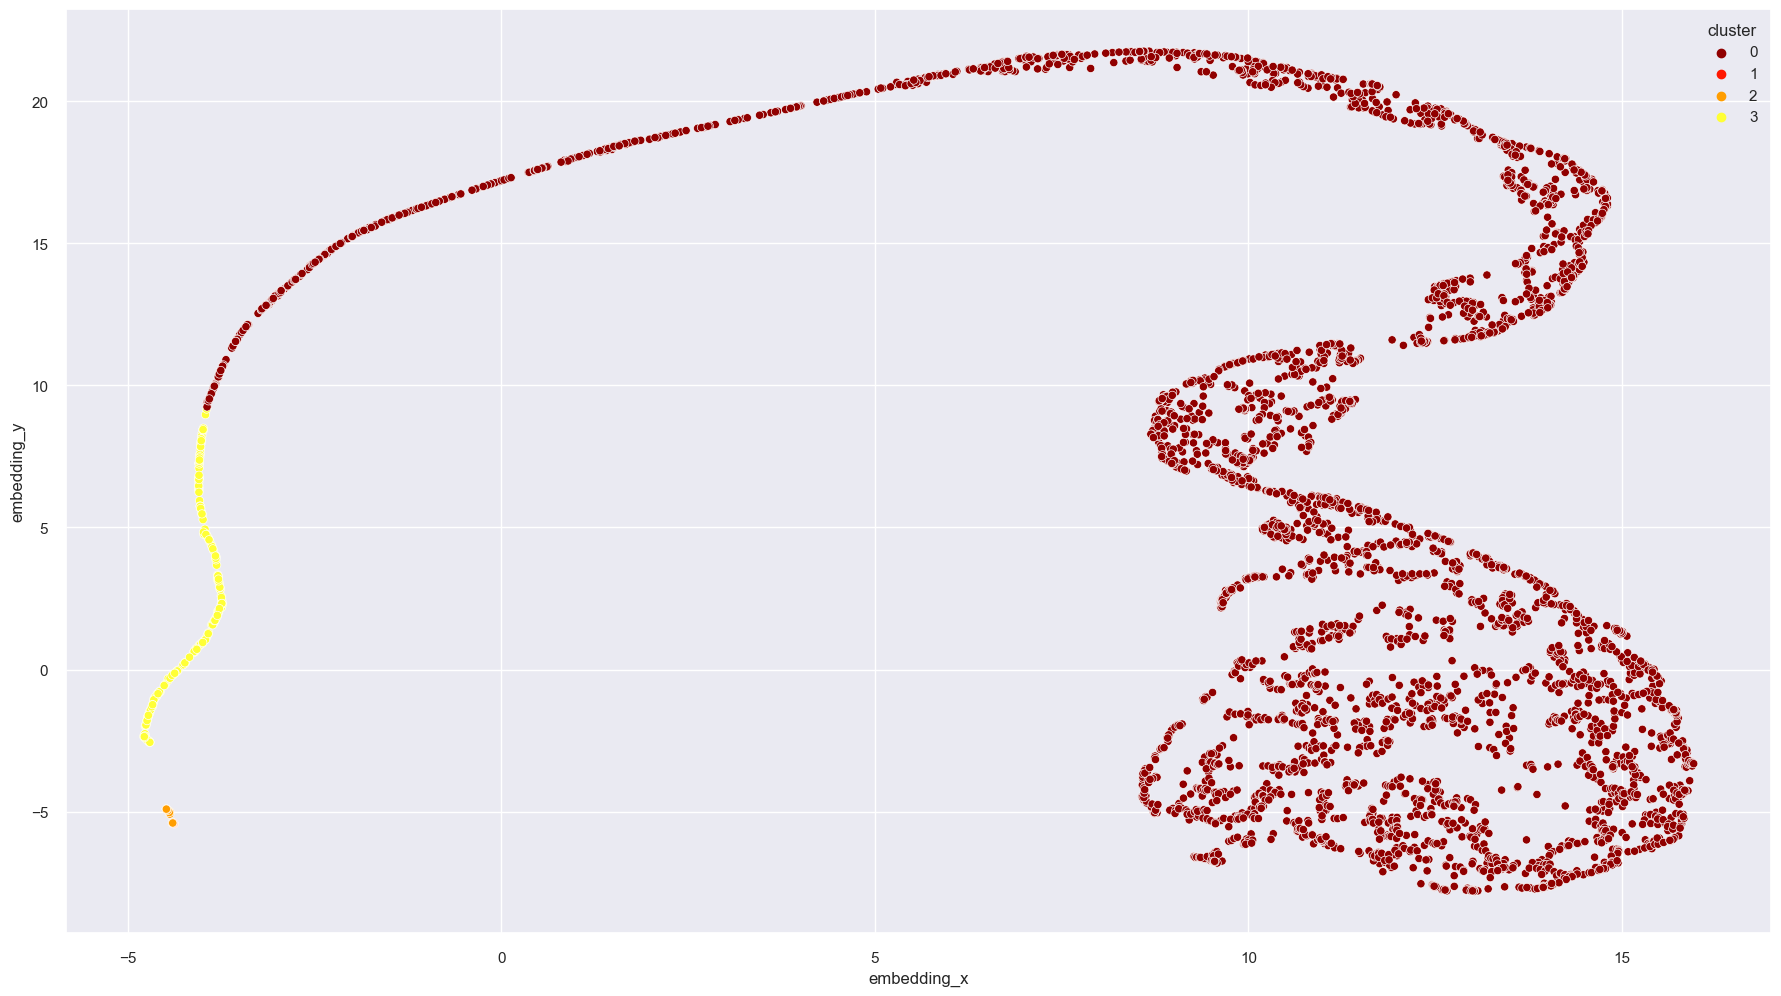

In [47]:
reducer = umap.UMAP(n_neighbors=20,random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hot', n_colors=len(df_viz['cluster'].unique())),
                data=df_viz)

## <font color='black'> 9.2 Cluster Profile  </font>

In [48]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Avg ticket
df_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')


In [49]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


# <font color='blue'> 10.0 Deploy to Production </font>